![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 22 - Clasificación multiclase II

Comentamos en la sesión anterior que muchos algoritmos de clasificación únicamente pueden ser utilizados en tareas de clasificación binaria.

En esta sesión vamos a ver dos métodos existentes para adaptar los algoritmos de clasificación binaria para que puedan trabajar en tareas de clasificación multiclase. Estos dos métodos se conocen como:

- one-vs-one (ovo): donde el conjunto de datos se descompone en varios conjuntos en los que las clases se enfrentan por pares.
- one-vs-rest (ovr) o one-vs-all (ova): donde el conjunto de datos se descompone en varios conjuntos donde una clase frente al resto de clases.

Vamos a cargar un conjunto de datos de tres clases y dos atributos para poder entender mejor estos métodos:


#####################################################
#### Cargamos conjunto de datos
#####################################################


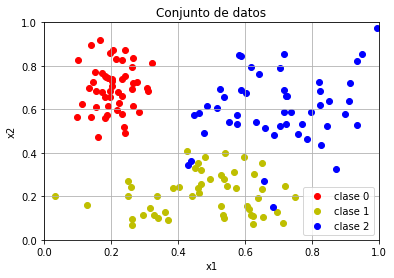

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC


def pinta(X_clase0, X_clase1, X_clase2, texto):
    fig, ax = plt.subplots()
    ax.scatter(X_clase0[:, 0], X_clase0[:, 1], c='r', label='clase 0')
    ax.scatter(X_clase1[:, 0], X_clase1[:, 1], c='y', label='clase 1')
    ax.scatter(X_clase2[:, 0], X_clase2[:, 1], c='b', label='clase 2')
    ax.set_xlabel('x1')
    ax.set_title(texto)
    ax.set_ylabel('x2')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()


print("\n#####################################################")
print("#### Cargamos conjunto de datos")
print("#####################################################")

df = pd.read_excel('ejemplo.xlsx', sheet_name='datos')
filas, columnas = df.shape

# separamos las primeras columnas y las almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase
y = df.iloc[:,(columnas-1)]

pinta(X[y==0].values, X[y==1].values, X[y==2].values, 'Conjunto de datos')

En el gráfico vemos bien identificadas las 3 clases, estando dos de ellas un poco entremezcladas.

## 22.1 One-vs-one

En el método one-vs-one se enfrentan las clases dos a dos para generar modelos que sean capaces de distinguirlas. 

Esto supone que se debe descomponer el conjunto de datos en los siguientes subconjuntos:

![Clase 0 vs 1](fig_0vs1_small.png) 
![Clase 0 vs 2](fig_0vs2_small.png) 
![Clase 1 vs 2](fig_1vs2_small.png) 

En general, si tenemos $N$ clases se generarán $\frac{N(N-1)}{2}$ subconjuntos de datos y habrá que crear un modelo para cada subconjunto.

Para predecir la clase de un ejemplo se recurre a la votación: la clase que más votos reciba será la predicha.

Este método tiene la ventaja de que los modelos aprendidos suelen ser más simples al estar implicadas únicamente dos clases en cada modelo.

Para aplicar este método debemos emplear `OneVsOneClassifier`: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html?highlight=onevsone#sklearn.multiclass.OneVsOneClassifier 

Veámoslo en acción:


##########################################
### Hold-out 70-30
##########################################

##########################################
### Aplicamos OneVsOneClassifier
##########################################
Accuracy: 0.9556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      1.00      0.94        15
           2       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



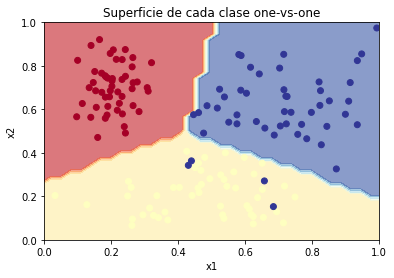

In [2]:
print('\n##########################################')
print('### Hold-out 70-30')
print('##########################################')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

print('\n##########################################')
print('### Aplicamos OneVsOneClassifier')
print('##########################################')

# creamos una instancia de one-vs-one con una regresión logística como algoritmo base
sys_rl_ovo = OneVsOneClassifier(LogisticRegression())
sys_rl_ovo.fit(X_train, y_train)
y_pred = sys_rl_ovo.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_rl_ovo, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase one-vs-one')
plt.show()

El sistema calculó los tres modelos y al combinarlos resultan las regiones que vemos. Son unas regiones bastante razonables.

## 22.2 One-vs-rest

En el método one-vs-rest, se aprende un modelo binario para cada clase. Este modelo trata de separar los ejemplos de esa clase de los ejemplos del resto de clases. 

Por tanto se deben crear conjuntos de datos de la siguiente manera, donde los ejemplos que aparecen con el mismo color se consideran de una misma clase:

![Clase 0 vs rest](fig_0vsRest_small.png) 
![Clase 1 vs rest](fig_1vsRest_small.png) 
![Clase 2 vs rest](fig_2vsRest_small.png) 

Y se aprenderá un modelo para cada clase.  

Cuando se quiere clasificar un ejemplo, se predice la clase que mayor probabilidad tenga (si el sistema base predice probabilidades) o la clase en la que el ejemplo esté más alejado de su frontera de decisión.

Este método presenta un par de ventajas:
- Es computacionalmente más eficiente. Si tenemos $N$ clases, únicamente se deben entrenar $N$ modelos, mientras que en one-vs-one se deben entrenar $\frac{N(N-1)}{2}$. Con pocas clases no se aprecia demasiado la diferencia, pero si tuviésemos 10 clases, en one-vs-rest se entrenarían 10 modelos mientras que en one-vs-one se entrenarían 45 modelos $\left(\frac{10(10-1)}{2}\right)$.
- Es más interpretable que one-vs-one, puesto que se podría inspeccionar el modelo correspondiente a una clase para tratar de explicar la toma de decisiones del modelo.


##########################################
### Aplicamos OneVsRestClassifier
##########################################
Accuracy: 0.9333
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.88      1.00      0.94        15
           2       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



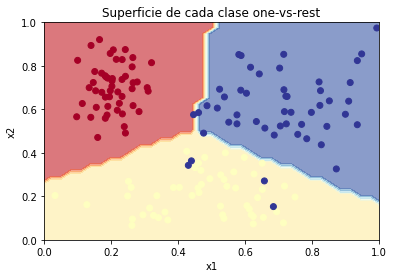

In [3]:
print('\n##########################################')
print('### Aplicamos OneVsRestClassifier')
print('##########################################')

# creamos una instancia de one-vs-rest con una regresión logística como algoritmo base
sys_rl_ovr = OneVsRestClassifier(LogisticRegression())
sys_rl_ovr.fit(X_train, y_train)
y_pred = sys_rl_ovr.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_rl_ovr, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase one-vs-rest')
plt.show()

Para este conjunto vemos que one-vs-rest tiene un rendimiento un poco inferior, pero no tiene por qué ser siempre así. Es más, la tendencia general es que el uso de one-vs-rest se está imponiendo y eso se debe a que, además de las ventajas que indicamos anteriormente, presenta un rendimiento comparable al que se obtiene con one-vs-one.

Como vemos, en este conjunto de datos las regiones son bastante similares y seguramente ajustando el hiperparámetro `C` de la regresión logística podríamos obtener un mejor rendimiento.

## 22.3 Los clasificadores binarios más populares ya están adaptados

Cuando se utilizan este tipo de métodos para adaptar algoritmos a clasificación multiclase, dependiendo de cada algoritmo, puede haber ciertas acciones que puedan hacerse de tal forma que el aprendizaje sea más rápido o que los modelos resultantes ocupen menos espacio.

Por esta razón, los algoritmos más populares ya tienen programada internamente la posibilidad de adaptarse a una tarea de clasificación multiclase y no necesitan utilizar instancias de `OneVsOneClassifier` o `OneVsRestClassifier`.

### 22.3.1 Regresión logística

El algoritmo `LogisticRegression` tiene un método particular para su adaptación a tareas multiclase. Este método se conoce como la **regresión logística multinomial** (o regresión logística softmax). En él se aprende una función para cada clase y se aplica posteriormente una función softmax para obtener la probabilidad de cada clase.

La implementación de `LogisticRegression` nos permite utilizar también la estrategia one-vs-rest para abordar tareas multiclase.

Por defecto se utiliza la regresión logística multinomial, pero utilizando el parámetro `multi_class` podemos seleccinar el método a utilizar: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression

Veamos una ejecución con ambos métodos:

Accuracy: 0.9333
Accuracy: 0.9333


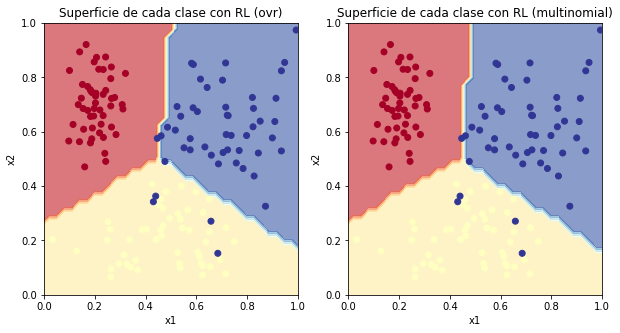

In [4]:
# creamos una instancia de una regresión logística
sys_rl = LogisticRegression() 

# creamos una figura con 2 gráficas
fig, sub = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

col = 0
for tipo in ['ovr', 'multinomial']: 
    sys_rl.set_params(multi_class=tipo) # asignamos el tipo de multiclass
    sys_rl.fit(X_train, y_train)
    y_pred = sys_rl.predict(X_test)
    print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

    # mostramos el informe de clasificación
    # print(metrics.classification_report(y_test, y_pred))

    # se genera el display con el espacio coloreado
    disp = DecisionBoundaryDisplay.from_estimator(sys_rl, X, response_method="predict", cmap=plt.cm.RdYlBu, 
                    ax=sub[col], alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

    # se incorporan los datos
    sub[col].scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

    sub[col].set_xlim([0, 1])
    sub[col].set_ylim([0, 1])
    sub[col].set_title('Superficie de cada clase con RL ('+tipo+')')
    col = col + 1

No se aprecian apenas diferencias ya que el problema es muy sencillo.

### 22.3.2 Máquinas de vectores soporte

En el caso de las SVM, la implementación que hay en `scikit-learn` nos permite seleccionar entre las estrategias one-vs-rest y one-vs-one, aunque por defecto se utiliza el método one-vs-rest.

A veces no se obtiene el mismo resultado utilizando `SVC()` y `OneVsRestClassifier(SVC())` aunque por lo que acabamos de explicar debería obtenerse el mismo resultado. Esto se debe a que el `SVC` utiliza una implementación de SVM ya implementada en el lenguaje C. Cuando se resuelve un problema multiclase utilizando `OneVsRestClassifier(SVC())`, parte del método es desarrollado por `scikit-learn` y otra parte por esa implementación externa en lenguaje C, y cuando se utiliza solo `SCV()` el método es llevado a cabo únicamente por la implentación externa, que al tener ciertas diferencias de implementación provoca que los resultados no sean los mismos siempre.

Para seleccionar el método que queramos utilizar debemos modificar el parámetro `decision_function_shape`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC

Vamos a ejecutarlo:

Accuracy: 0.9556
Accuracy: 0.9556


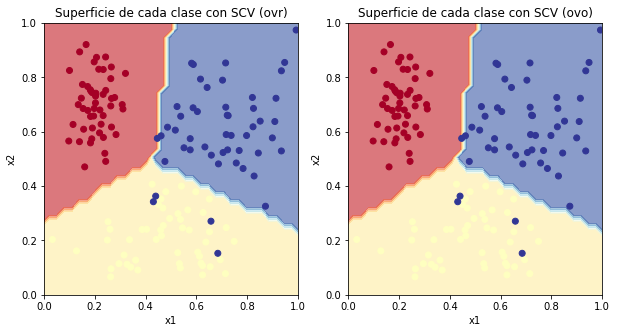

In [5]:
# creamos una instancia de SVC con kernel lineal
sys_svc = SVC(kernel='linear') 

# creamos una figura con 2 gráficas
fig, sub = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

col = 0
for tipo in ['ovr', 'ovo']: 
    sys_svc.set_params(decision_function_shape=tipo) # asignamos el tipo de multiclass
    sys_svc.fit(X_train, y_train)
    y_pred = sys_svc.predict(X_test)
    print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

    # mostramos el informe de clasificación
    # print(metrics.classification_report(y_test, y_pred))

    # se genera el display con el espacio coloreado
    disp = DecisionBoundaryDisplay.from_estimator(sys_svc, X, response_method="predict", cmap=plt.cm.RdYlBu, 
                    ax=sub[col], alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

    # se incorporan los datos
    sub[col].scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

    sub[col].set_xlim([0, 1])
    sub[col].set_ylim([0, 1])
    sub[col].set_title('Superficie de cada clase con SCV ('+tipo+')')
    col = col + 1

No se aprecian diferencias por la sencillez del problema.

Si en lugar de utilizar un kernel lineal hubiésemos utilizado un kernel polinómico o RBF las regiones habrían resultado más redondeadas. Puedes probar.

## Ejercicios

1. Carga los datos de la pestaña "FHR" que hay en el fichero **CTG.xls**. 
2. Se debe calcular para los sistemas vistos en esta sesión (y en la sesión anterior) las métricas accuracy y las medias ponderadas de precision, recall y F1.
3. Presentar los resultados en forma de tabla.

Estos ejercicios no es necesario entregarlos.